In [2]:
from datasets import load_dataset

ds = load_dataset("ckandemir/bitcoin_tweets_sentiment_kaggle")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001-cc8461398e2665(…):   0%|          | 0.00/7.92M [00:00<?, ?B/s]

data/test-00000-of-00001-922aa1040603455(…):   0%|          | 0.00/997k [00:00<?, ?B/s]

data/eval-00000-of-00001-dc793d916ae447c(…):   0%|          | 0.00/949k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/77791 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/9724 [00:00<?, ? examples/s]

Generating eval split:   0%|          | 0/9724 [00:00<?, ? examples/s]

In [3]:
ds

DatasetDict({
    train: Dataset({
        features: ['Date', 'text', 'Sentiment'],
        num_rows: 77791
    })
    test: Dataset({
        features: ['Date', 'text', 'Sentiment'],
        num_rows: 9724
    })
    eval: Dataset({
        features: ['Date', 'text', 'Sentiment'],
        num_rows: 9724
    })
})

In [5]:
import pandas as pd

df = ds['train'].to_pandas()

df.head()


,Date,text,Sentiment
0,2019-06-12,Are you interested in Bitcoin mining for FREE!...,Positive
1,2019-07-08,"QA Analyst - IT Services Company ( WESTBURY, U...",Positive
2,2019-05-22,🌍22/05/2019🌍\nA Abakus a qual a NovaDAX perten...,Negative
3,2019-05-16,@Quark_Chain #QKC #Blockchain #BTC #ETH #block...,Negative
4,2018-07-21,"July 21, 2018 04:00 AM EDT\nLast 4 hours, BTC ...",Positive


In [6]:
df.shape

(77791, 3)

In [7]:
df.columns

Index(['Date', 'text', 'Sentiment'], dtype='object')

In [9]:
df['Sentiment'].value_counts()


,count
Sentiment,
Positive,40151
Negative,37637
Neutral,3


In [10]:
df = df[df['Sentiment'].isin(['Positive', 'Negative'])]
df['Sentiment'].value_counts()


,count
Sentiment,
Positive,40151
Negative,37637


In [11]:
n = 15000  # per class

pos = df[df['Sentiment'] == 'Positive'].sample(n, random_state=42)
neg = df[df['Sentiment'] == 'Negative'].sample(n, random_state=42)

df = pd.concat([pos, neg]).sample(frac=1, random_state=42)
df.shape


(30000, 3)

In [12]:
import re

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"#", "", text)
    text = re.sub(r"[^a-z\s]", "", text)
    return text.strip()

df['clean_text'] = df['text'].apply(clean_text)


In [13]:
df['label'] = df['Sentiment'].map({'Negative': 0, 'Positive': 1})


In [14]:
from sklearn.model_selection import train_test_split

X = df['clean_text']
y = df['label']

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42
)


In [15]:
from sklearn.feature_extraction.text import CountVectorizer

bow_vectorizer = CountVectorizer(
    ngram_range=(1,2),
    min_df=2
)

X_train_bow = bow_vectorizer.fit_transform(X_train)
X_test_bow = bow_vectorizer.transform(X_test)


In [16]:
from sklearn.linear_model import LogisticRegression

bow_clf = LogisticRegression(max_iter=1000)
bow_clf.fit(X_train_bow, y_train)


LogisticRegression(max_iter=1000)

In [17]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred_bow = bow_clf.predict(X_test_bow)

print("Bag-of-Words + Logistic Regression")
print(classification_report(y_test, y_pred_bow))
print(confusion_matrix(y_test, y_pred_bow))


Bag-of-Words + Logistic Regression
              precision    recall  f1-score   support

           0       0.60      0.62      0.61      2250
           1       0.61      0.59      0.60      2250

    accuracy                           0.60      4500
   macro avg       0.60      0.60      0.60      4500
weighted avg       0.60      0.60      0.60      4500

[[1401  849]
 [ 933 1317]]


In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(
    ngram_range=(1,2),
    min_df=2,
    sublinear_tf=True
)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)


In [19]:
from sklearn.svm import LinearSVC

tfidf_clf = LinearSVC()
tfidf_clf.fit(X_train_tfidf, y_train)


LinearSVC()

In [20]:
y_pred_tfidf = tfidf_clf.predict(X_test_tfidf)

print("TF-IDF + Linear SVM")
print(classification_report(y_test, y_pred_tfidf))
print(confusion_matrix(y_test, y_pred_tfidf))


TF-IDF + Linear SVM
              precision    recall  f1-score   support

           0       0.62      0.57      0.59      2250
           1       0.60      0.65      0.62      2250

    accuracy                           0.61      4500
   macro avg       0.61      0.61      0.61      4500
weighted avg       0.61      0.61      0.61      4500

[[1284  966]
 [ 792 1458]]


In [21]:
!wget http://nlp.stanford.edu/data/glove.twitter.27B.zip
!unzip glove.twitter.27B.zip


--2025-12-14 10:26:46--  http://nlp.stanford.edu/data/glove.twitter.27B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.twitter.27B.zip [following]
--2025-12-14 10:26:46--  https://nlp.stanford.edu/data/glove.twitter.27B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip [following]
--2025-12-14 10:26:46--  https://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1520408563 (1.4G) [ap

In [22]:
import numpy as np

embedding_dim = 100
embeddings = {}

with open("glove.twitter.27B.100d.txt", encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype="float32")
        embeddings[word] = vector


In [23]:
def document_vector(text, embeddings, dim=100):
    words = text.split()
    vectors = [embeddings[w] for w in words if w in embeddings]
    if len(vectors) == 0:
        return np.zeros(dim)
    return np.mean(vectors, axis=0)

X_train_w2v = np.vstack([document_vector(t, embeddings) for t in X_train])
X_test_w2v  = np.vstack([document_vector(t, embeddings) for t in X_test])


In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

w2v_clf = LogisticRegression(max_iter=1000)
w2v_clf.fit(X_train_w2v, y_train)

y_pred_w2v = w2v_clf.predict(X_test_w2v)

print("Word2Vec (Averaged) + Logistic Regression")
print(classification_report(y_test, y_pred_w2v))
print(confusion_matrix(y_test, y_pred_w2v))


Word2Vec (Averaged) + Logistic Regression
              precision    recall  f1-score   support

           0       0.64      0.45      0.53      2250
           1       0.58      0.75      0.65      2250

    accuracy                           0.60      4500
   macro avg       0.61      0.60      0.59      4500
weighted avg       0.61      0.60      0.59      4500

[[1004 1246]
 [ 553 1697]]


In [25]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=20000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq   = tokenizer.texts_to_sequences(X_val)
X_test_seq  = tokenizer.texts_to_sequences(X_test)

max_len = int(np.percentile([len(x) for x in X_train_seq], 95))

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding="post")
X_val_pad   = pad_sequences(X_val_seq, maxlen=max_len, padding="post")
X_test_pad  = pad_sequences(X_test_seq, maxlen=max_len, padding="post")


In [26]:
word_index = tokenizer.word_index
num_words = min(20000, len(word_index) + 1)

embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in word_index.items():
    if i < num_words and word in embeddings:
        embedding_matrix[i] = embeddings[word]


In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense

model = Sequential([
    Embedding(
        input_dim=num_words,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        input_length=max_len,
        trainable=False
    ),
    SimpleRNN(64),
    Dense(1, activation="sigmoid")
])

model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,000,000 (7.63 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,000,000 (7.63 MB)

In [28]:
history = model.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    epochs=5,
    batch_size=64
)


Epoch 1/5
329/329 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.6027 - loss: 0.6514 - val_accuracy: 0.5604 - val_loss: 0.6483
Epoch 2/5
329/329 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.6157 - loss: 0.6092 - val_accuracy: 0.5782 - val_loss: 0.6513
Epoch 3/5
329/329 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.6203 - loss: 0.6191 - val_accuracy: 0.5951 - val_loss: 0.6256
Epoch 4/5
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.6275 - loss: 0.5996 - val_accuracy: 0.6147 - val_loss: 0.6102
Epoch 5/5
329/329 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.6450 - loss: 0.5874 - val_accuracy: 0.5902 - val_loss: 0.6189


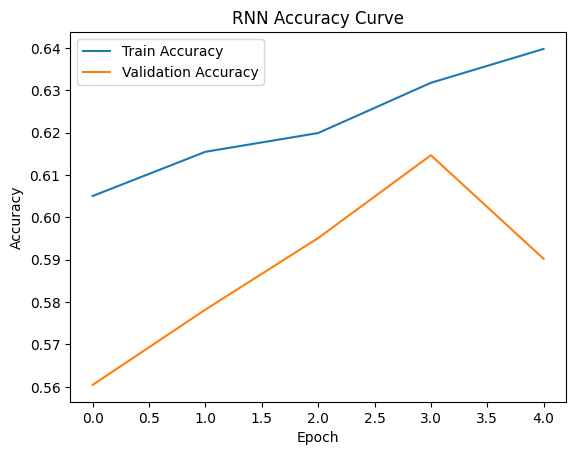

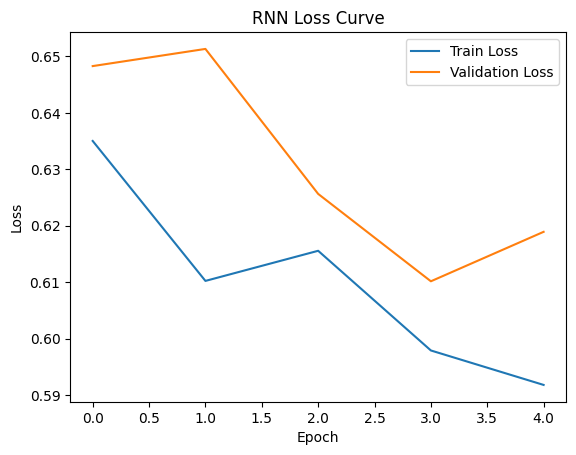

In [29]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('RNN Accuracy Curve')
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('RNN Loss Curve')
plt.show()


In [31]:
from sklearn.metrics import f1_score


In [32]:
bow_f1 = f1_score(y_test, y_pred_bow)


In [33]:
tfidf_f1 = f1_score(y_test, y_pred_tfidf)


In [34]:
w2v_f1 = f1_score(y_test, y_pred_w2v)


In [36]:
y_pred_rnn_prob = model.predict(X_test_pad)


141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


In [37]:
y_pred_rnn = (y_pred_rnn_prob > 0.5).astype(int)


In [38]:

y_pred_rnn = y_pred_rnn.flatten()


In [39]:
from sklearn.metrics import f1_score

rnn_f1 = f1_score(y_test, y_pred_rnn)
rnn_f1


0.5780240073868883

In [40]:
import numpy as np
print("y_test shape:", y_test.shape)
print("y_pred_rnn shape:", y_pred_rnn.shape)
print("Unique preds:", np.unique(y_pred_rnn))


y_test shape: (4500,)
y_pred_rnn shape: (4500,)
Unique preds: [0 1]


In [41]:
results_df = pd.DataFrame({
    "Model": [
        "BoW + Logistic Regression",
        "TF-IDF + Linear SVM",
        "Word2Vec Avg + Logistic Regression",
        "Simple RNN"
    ],
    "F1-score": [
        bow_f1,
        tfidf_f1,
        w2v_f1,
        rnn_f1
    ]
})

results_df


,Model,F1-score
0,BoW + Logistic Regression,0.596467
1,TF-IDF + Linear SVM,0.623877
2,Word2Vec Avg + Logistic Regression,0.653572
3,Simple RNN,0.578024


In [42]:
import pandas as pd

test_df = pd.DataFrame({
    "text": X_test.values,
    "true": y_test.values,
    "bow_pred": y_pred_bow,
    "tfidf_pred": y_pred_tfidf,
    "w2v_pred": y_pred_w2v,
    "rnn_pred": y_pred_rnn
})

test_df.head()


,text,true,bow_pred,tfidf_pred,w2v_pred,rnn_pred
0,ah,1,0,0,1,1
1,ooobtc obx crypto bitcoin ethereum blockchain ...,0,1,1,1,0
2,prices update in usdt hour\n\nbtc \neth ...,0,1,1,1,0
3,one bitcoin now worth high low market cap ...,0,1,1,0,0
4,you ought to take your time to check this the ...,1,1,1,1,1


In [43]:
tfidf_wrong_rnn_correct = test_df[
    (test_df['tfidf_pred'] != test_df['true']) &
    (test_df['rnn_pred'] == test_df['true'])
]


In [44]:
rnn_wrong_tfidf_correct = test_df[
    (test_df['rnn_pred'] != test_df['true']) &
    (test_df['tfidf_pred'] == test_df['true'])
]


In [45]:
both_wrong = test_df[
    (test_df['rnn_pred'] != test_df['true']) &
    (test_df['tfidf_pred'] != test_df['true'])
]


In [46]:
both_wrong = test_df[
    (test_df['rnn_pred'] != test_df['true']) &
    (test_df['tfidf_pred'] != test_df['true'])
]


In [47]:
examples = pd.concat([
    tfidf_wrong_rnn_correct.sample(2, random_state=42),
    rnn_wrong_tfidf_correct.sample(2, random_state=42),
    both_wrong.sample(1, random_state=42)
])

examples


,text,true,bow_pred,tfidf_pred,w2v_pred,rnn_pred
3422,btc btc bitcoins current price h h ...,0,1,1,1,0
2551,crypto exchange review \n\n\n\nbitcoin ethereu...,0,0,1,1,0
1785,bitcoin price prediction for new highs short t...,0,0,0,0,1
4047,ceo\n\nbtc,0,0,0,0,1
3609,im here for the same reason everyone is here o...,0,1,1,1,1


In [48]:
new_tweet = "BTC looks strong, breakout coming soon"


In [49]:
clean_tweet = clean_text(new_tweet)


In [50]:
X_new_tfidf = tfidf_vectorizer.transform([clean_tweet])
prediction = tfidf_clf.predict(X_new_tfidf)[0]

label = "Bullish" if prediction == 1 else "Bearish"
label


'Bullish'

In [51]:
X_new_w2v = document_vector(clean_tweet, embeddings).reshape(1, -1)
prediction = w2v_clf.predict(X_new_w2v)[0]

label = "Bullish" if prediction == 1 else "Bearish"
label


'Bearish'

In [52]:
seq = tokenizer.texts_to_sequences([clean_tweet])
pad = pad_sequences(seq, maxlen=max_len, padding="post")

prob = model.predict(pad)[0][0]
prediction = 1 if prob > 0.5 else 0

label = "Bullish" if prediction == 1 else "Bearish"
label


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


'Bearish'

In [53]:
def predict_sentiment(tweet, model_type="tfidf"):
    clean = clean_text(tweet)

    if model_type == "tfidf":
        vec = tfidf_vectorizer.transform([clean])
        pred = tfidf_clf.predict(vec)[0]

    elif model_type == "w2v":
        vec = document_vector(clean, embeddings).reshape(1, -1)
        pred = w2v_clf.predict(vec)[0]

    else:  # rnn
        seq = tokenizer.texts_to_sequences([clean])
        pad = pad_sequences(seq, maxlen=max_len)
        prob = model.predict(pad)[0][0]
        pred = 1 if prob > 0.5 else 0

    return "Bullish" if pred == 1 else "Bearish"
